In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import os
import re
import numpy as np
import pandas as pd
from tensorflow.python.platform import gfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import random
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

Using TensorFlow backend.


In [2]:
######################################
# Loading images & their class for each catgory
######################################

In [3]:
#image size to be used
#using lower pixel_size because of the memory and time constraints
#please change this to a desired value (if required)
pixel_size = 28

In [4]:
images_dir1 = 'input/'
list_images1 = [images_dir1+f for f in os.listdir(images_dir1) if re.search('jpeg|JPEG|jpg', f)]

In [5]:
# Loading category 1: Plant, flora, plant life

train_1 = np.zeros(shape=(len(list_images1),pixel_size*pixel_size,3))
count = 0
for i in list_images1:
    img = Image.open(i)  
    img = img.resize((pixel_size, pixel_size))
    x = img_to_array(img)
    if (x.shape[2]==1):
        x = x.reshape(1,pixel_size*pixel_size,1)
    else:
        x = x.reshape(1,pixel_size*pixel_size,3)
    train_1[count] = x
    count += 1

In [6]:
train_1.shape

(20, 784, 3)

In [7]:
train_1 = np.reshape(train_1, (len(train_1), pixel_size,pixel_size, 3))  
train_1 = train_1[:18,:,:]

In [8]:
train_1.shape

(18, 28, 28, 3)

In [9]:
# Generating classes for each category

train_1_class = np.array([1,1,1,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2])

In [10]:
train_1_class.shape

(18,)

In [11]:
######################################
# Function calls
######################################

In [12]:
# Function call to split the training and testing data 

def train_test_split(train,train_class):
    seq = list(range(0,train.shape[0]))
    random.shuffle(seq)

    x_train = train[seq[:int(0.80*len(seq))]]
    x_train_class = train_class[seq[:int(0.80*len(seq))]]

    x_test = train[seq[int(0.80*len(seq)):]]
    x_test_class = train_class[seq[int(0.80*len(seq)):]]
    return (x_train,x_train_class,x_test,x_test_class)

In [13]:
# Function call to calculate the euclidean distance, confusion matrix and accuracy 

def euclidean_distance(encoded_imgs_train,x_train_class,encoded_imgs_test,x_test_class):
    #euclidean_distance
    majority_class=[]
    euclidean_dist = np.zeros(shape=(encoded_imgs_train.shape[0]))
    for i in range(0,encoded_imgs_test.shape[0]):
        for j in range(0,encoded_imgs_train.shape[0]):
            euclidean_dist[j] = ((np.array(encoded_imgs_test[i] - encoded_imgs_train[j]))**2).sum(axis=0).sum(axis=0).sum(axis=0)
        top5 = euclidean_dist.argsort()[:5][::-1]
        majority_class.append(np.argmax(np.bincount(list(x_train_class[top5]))))

    df = pd.DataFrame(majority_class,columns=['predict_class'])
    df['true_class'] = x_test_class
    cm = confusion_matrix(df['true_class'], df['predict_class'])#, labels=lp_model.classes_)
    print ("\nConfusion Matrix")
    print (cm)
    accuracy = 0
    for i in range(0,2):
        accuracy += cm[i][i]
    print ("\nOverall accuracy : ",100*(accuracy/df.shape[0]),"%")

In [14]:
# Function call to calculate the pearson correlation coefficient, confusion matrix and accuracy

def pearson_corr_coeff(encoded_imgs_train,x_train_class,encoded_imgs_test,x_test_class):
    majority_class=[]
    pearson_correlation = np.zeros(shape=(encoded_imgs_train.shape[0]))
    for i in range(0,encoded_imgs_test.shape[0]):
        for j in range(0,encoded_imgs_train.shape[0]):
            pearson_correlation[j] = pearsonr(encoded_imgs_test[i].flatten(), encoded_imgs_train[j].flatten())[0]
        top5 = pearson_correlation.argsort()[:5][::-1]
        majority_class.append(np.argmax(np.bincount(list(x_train_class[top5]))))

    df = pd.DataFrame(majority_class,columns=['predict_class'])
    df['true_class'] = x_test_class
    cm = confusion_matrix(df['true_class'], df['predict_class'])#, labels=lp_model.classes_)
    print ("\nConfusion Matrix")
    print (cm)
    accuracy = 0
    for i in range(0,2):
        accuracy += cm[i][i]
    print ("\nOverall accuracy : ",100*(accuracy/df.shape[0]),"%")

In [15]:
# Function call to calculate the pearson correlation coefficient, confusion matrix and accuracy

def pearson_corr_coeff1(encoded_imgs_train,x_train_class,encoded_imgs_test,x_test_class):
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=5,algorithm='brute',metric='correlation')
    neigh.fit(encoded_imgs_train, x_train_class)
    majority_class = neigh.predict(encoded_imgs_test)

    df = pd.DataFrame(majority_class,columns=['predict_class'])
    df['true_class'] = x_test_class
    cm = confusion_matrix(df['true_class'], df['predict_class'])#, labels=lp_model.classes_)
    print ("\nConfusion Matrix")
    print (cm)
    accuracy = 0
    for i in range(0,2):
        accuracy += cm[i][i]
    print ("\nOverall accuracy : ",100*(accuracy/df.shape[0]),"%")

In [16]:
######################################
# creating autoencoder
######################################
# Justification for the autoencoder
# I used CNN autoencoder as CNN works best for images.
# Our inputs being images, it makes sense to use CNN as encoders and decoders.
# The encoder consist of a stack of Conv2D and MaxPooling2D layers
# and the decoder consist of a stack of Conv2D and UpSampling2D layers.
# 2 convolution layers and 2 pooling layers with activation function = relu for encoder
# 2 convolution layers and 2 upsampling layers with activation function = relu for decoder
# The reason for chosing this specification is that it gave the best results 
# in the previous question among the different CNN architectures tried.

In [17]:

input_img = Input(shape=(pixel_size,pixel_size, 3))  # adapt this if using `channels_first` image data format
input_img

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

encoder1 = Model(input_img, encoded)
autoencoder1 = Model(input_img, decoded)
autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy')

In [18]:
x_train,x_train_class,x_test,x_test_class = train_test_split(train_1,train_1_class)

In [19]:
x_test.shape

(4, 28, 28, 3)

In [20]:
autoencoder1.fit(x_train, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder1')])

#autoencoder1.fit(train_1, train_1,
#                epochs=1,
#                batch_size=128,
#                shuffle=True,
#                validation_data=(train_1, train_1),
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder1')])

Train on 14 samples, validate on 4 samples
Epoch 1/1
14/14 [==============================] - 0s - loss: 321.8404 - val_loss: 158.5017


In [21]:
encoded_imgs_test = encoder1.predict(x_test)
encoded_imgs_train = encoder1.predict(x_train)

encoded_imgs_test = np.reshape(encoded_imgs_test, (encoded_imgs_test.shape[0], encoded_imgs_test.shape[1]*encoded_imgs_test.shape[2]*encoded_imgs_test.shape[3])) 
encoded_imgs_train = np.reshape(encoded_imgs_train, (encoded_imgs_train.shape[0], encoded_imgs_train.shape[1]*encoded_imgs_train.shape[2]*encoded_imgs_train.shape[3])) 

In [22]:
#encoded_imgs_test = encoder1.predict(train_1)
#encoded_imgs_train = encoder1.predict(train_1)

#encoded_imgs_test = np.reshape(encoded_imgs_test, (encoded_imgs_test.shape[0], encoded_imgs_test.shape[1]*encoded_imgs_test.shape[2]*encoded_imgs_test.shape[3])) 
#encoded_imgs_train = np.reshape(encoded_imgs_train, (encoded_imgs_train.shape[0], encoded_imgs_train.shape[1]*encoded_imgs_train.shape[2]*encoded_imgs_train.shape[3])) 

In [23]:
euclidean_distance(encoded_imgs_train,x_train_class,encoded_imgs_test,x_test_class)
#euclidean_distance(encoded_imgs_train,train_1_class,encoded_imgs_test,train_1_class)


Confusion Matrix
[[2 0]
 [0 2]]

Overall accuracy :  100.0 %


In [24]:
pearson_corr_coeff1(encoded_imgs_train,x_train_class,encoded_imgs_test,x_test_class)
#pearson_corr_coeff1(encoded_imgs_train,train_1_class,encoded_imgs_test,train_1_class)


Confusion Matrix
[[1 1]
 [0 2]]

Overall accuracy :  75.0 %


In [25]:
######################################
# creating SVD
######################################
# Justification for the value of k
# I tried different values of k ranging from
# 10,100,200,400,500,700,800,1000 etc.
# value of K for ~700 gave the best results in
# terms of accuracy %. Hence, I chose k=700

In [27]:
k=700
train_svd = np.reshape(train_1, (len(train_1), pixel_size*pixel_size*3))
svd = TruncatedSVD(n_components=k, n_iter=7)
train_reduced = svd.fit_transform(train_svd)

In [28]:
x_train,x_train_class,x_test,x_test_class = train_test_split(train_reduced,train_1_class)

In [29]:
euclidean_distance(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[3 0]
 [0 1]]

Overall accuracy :  100.0 %


In [30]:
pearson_corr_coeff1(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[3 0]
 [0 1]]

Overall accuracy :  100.0 %


In [31]:
######################################
# creating RGB Histograms
######################################

In [40]:
train_rgb = np.reshape(train_1, (len(train_1), pixel_size*pixel_size, 3)) 
train_rgb = train_rgb
print (train_rgb.shape)
train_r = train_rgb[:,:,0]
train_g = train_rgb[:,:,1]
train_b = train_rgb[:,:,2]
print (train_r)

(18, 784, 3)
[[ 252.  253.  255. ...,   29.   29.   55.]
 [ 118.   82.   95. ...,   44.   93.   74.]
 [ 236.  240.  255. ...,   77.   94.  158.]
 ..., 
 [  52.  192.   85. ...,  168.   47.    4.]
 [  34.   38.    0. ...,  206.   23.   34.]
 [ 154.  208.  172. ...,  197.  189.  185.]]


In [41]:
train_r_count = []
train_g_count = []
train_b_count = []
for i in range(0,train_r.shape[0]):
    train_r_count.append (np.histogram(train_r[i],bins=list(range(0,257)))[0])
    train_g_count.append (np.histogram(train_g[i],bins=list(range(0,257)))[0])
    train_b_count.append (np.histogram(train_b[i],bins=list(range(0,257)))[0])
train_r_count = np.array(train_r_count)
train_g_count = np.array(train_g_count)
train_b_count = np.array(train_b_count)

print (train_r_count.shape,train_g_count.shape,train_b_count.shape)
#train_rgb1 = np.concatenate((train_rgb[:,:,0],train_rgb[:,:,1],train_rgb[:,:,2]),axis=1)
train_rgb1 = np.concatenate((train_r_count,train_g_count,train_b_count),axis=1)
print (train_rgb1.shape)

(18, 256) (18, 256) (18, 256)
(18, 768)


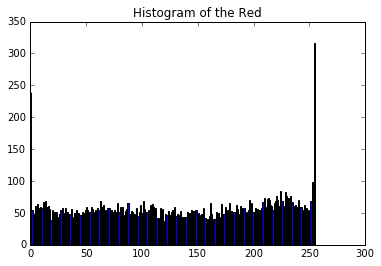

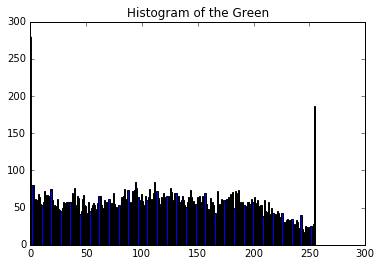

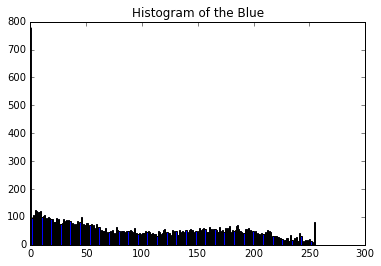

In [42]:
plt.hist(train_r.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Red")
plt.show()
plt.hist(train_g.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Green")
plt.show()
plt.hist(train_b.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Blue")
plt.show()

In [43]:
x_train,x_train_class,x_test,x_test_class = train_test_split(train_rgb1,train_1_class)

In [46]:
euclidean_distance(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[1 1]
 [2 0]]

Overall accuracy :  25.0 %


In [47]:
pearson_corr_coeff1(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[2 0]
 [0 2]]

Overall accuracy :  100.0 %


In [48]:
######################################
# creating HSV Histograms
######################################

In [49]:
from skimage import color
#train.shape
train_hsv = train_1
for i in range(0,train_1.shape[0]):
    train_hsv[i] = color.rgb2hsv(train_1[i])
#train_hsv.shape

In [58]:
train_hsv = np.reshape(train_1, (len(train_1), pixel_size*pixel_size, 3)) 
train_hsv = train_hsv
print (train_hsv.shape)
train_h = train_hsv[:,:,0]*256
train_s = train_hsv[:,:,1]*256
train_v = train_hsv[:,:,2]
print (train_h)

(18, 784, 3)
[[ 128.           18.28571429  213.33333333 ...,  152.70175439
    95.17948718   89.6       ]
 [ 154.66666667  154.32624113  151.12772586 ...,  151.94557823
   142.50666667  152.92883895]
 [  48.76190476   48.76190476   42.66666667 ...,  148.68686869
   156.09756098  187.73333333]
 ..., 
 [  22.45614035   10.44444444    8.34782609 ...,   24.38095238   54.3030303
   157.86666667]
 [ 156.06006006  155.7979798   149.96078431 ...,   40.14201183   89.6
   210.05128205]
 [  20.0091954    19.55555556   19.52069717 ...,   43.73333333
    42.66666667   44.4822695 ]]


In [59]:
train_h_count = []
train_s_count = []
train_v_count = []
for i in range(0,train_h.shape[0]):
    train_h_count.append (np.histogram(train_h[i],bins=list(range(0,257)))[0])
    train_s_count.append (np.histogram(train_s[i],bins=list(range(0,257)))[0])
    train_v_count.append (np.histogram(train_v[i],bins=list(range(0,257)))[0])
train_h_count = np.array(train_h_count)
train_s_count = np.array(train_s_count)
train_v_count = np.array(train_v_count)

print (train_h_count.shape,train_s_count.shape,train_v_count.shape)
#train_hsv1 = np.concatenate((train_hsv[:,:,0],train_hsv[:,:,1],train_hsv[:,:,2]),axis=1)
train_hsv1 = np.concatenate((train_h_count,train_s_count,train_v_count),axis=1)
print (train_hsv1.shape)

(18, 256) (18, 256) (18, 256)
(18, 768)


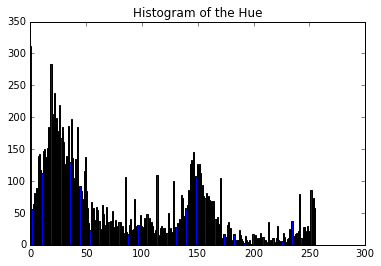

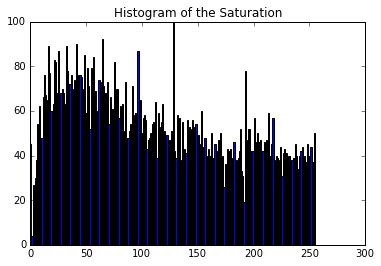

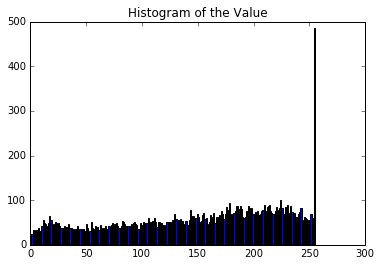

In [60]:
plt.hist(train_h.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Hue")
plt.show()
plt.hist(train_s.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Saturation")
plt.show()
plt.hist(train_v.flatten(), bins=list(range(0,256)))
plt.title("Histogram of the Value")
plt.show()

In [62]:
x_train,x_train_class,x_test,x_test_class = train_test_split(train_hsv1,train_1_class)

In [63]:
euclidean_distance(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[1 0]
 [3 0]]

Overall accuracy :  25.0 %


In [64]:
pearson_corr_coeff1(x_train,x_train_class,x_test,x_test_class)


Confusion Matrix
[[0 1]
 [2 1]]

Overall accuracy :  25.0 %


In [45]:
###########################################
# Results interpretation
# All the results of the overall accuracy 
# are around ~30%-44% which is much better
# than the average accuracy of 1/6=16.66%
# Hence, we can claim that the classifier
# are working better than the random guess
##########################################